In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy
import skimage
import sys
sys.path.append("../src/CellSNAP/")
from utils import *
import os
from tqdm import tqdm
from skimage.io import imread
from preprocessing import *
from datasets import *

/home/sheng/miniconda3/envs/super-resolution/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
from cellsnap import *

## Step I: Create spatial dataset

We first load the codex murine dataset

In [3]:
df = pd.read_csv('../data/codex_murine/features_and_metadata.csv', index_col = 0)

In [4]:
df.head()

,Unnamed: 0,cellLabelInImage,cellSize,CD45,Ly6C,TCR,Ly6G,CD19,CD169,CD106,...,CD35,CD2135,CD44,nucl,NKp46,cluster.term,centroid_x,centroid_y,field_of_view,cluster.termV2
0,1,3,283,0.000000,316.262419,595.768897,49.077602,608.994748,322.609557,0.000000,...,217.914412,69.250551,0.000000,9100.068826,572.555576,Other,7.717314,240.809187,1,Vessel
1,4,7,215,0.000000,0.000000,134.472468,0.000000,1431.469046,73.665657,0.000000,...,1135.190597,96.309696,0.000000,15071.640583,0.000000,B,5.916279,1334.600000,1,Other
2,5,11,397,0.000000,372.035233,899.713809,261.276071,605.481258,1023.287300,1152.344425,...,488.606413,245.895189,236.229915,16381.046106,769.252953,Other,9.277078,1167.989924,1,Vessel
3,7,13,500,2966.989105,337.537437,329.896108,37.743424,671.873764,51.828695,49.372156,...,0.000000,0.000000,942.795851,2283.347509,312.484433,B,11.430000,1026.952000,1,B
4,9,15,838,3797.157518,665.627685,1938.002387,368.658711,2616.937947,1682.991647,3003.585919,...,1822.097852,392.223150,5141.479714,23181.488067,575.791169,Mph,10.233890,656.547733,1,Mph


In [5]:
features_list = [
        'CD45',
        'Ly6C',
        'TCR',
        'Ly6G',
        'CD19',
        'CD169',
        'CD106',
        'CD3',
        'CD1632',
        'CD8a',
        'CD90',
        'F480',
        'CD11c',
        'Ter119',
        'CD11b',
        'IgD',
        'CD27',
        'CD5',
        'CD79b',
        'CD71',
        'CD31',
        'CD4',
        'IgM',
        'B220',
        'ERTR7',
        'MHCII',
        'CD35',
        'CD2135',
        'CD44',
        'nucl',
        'NKp46'
    ]

In [6]:
murine_dataset = SNAP_Dataset(df,
                             k=15,
                             feature_neighbor=15,
                             pca_components=25,
                             features_list=features_list,
                             path2img='../../data/tutorial/codex_murine/processed_images')

### Initialize the dataset

In [7]:
murine_dataset.initialize("centroid_x", "centroid_y", "feature_labels", resolution=0.5)

/home/sheng/miniconda3/envs/super-resolution/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Calculating cell neighborhood composition matrix...
Constructing the graph...
Done!


In [8]:
murine_dataset.dual_labels.shape

(53500, 30)

### Process Images

We first read in the raw images and concatenate them to form one entire view.

In [9]:
shape_of_each_view = (1008, 1344)
shape_of_views = (9, 7)
channels=('CD45', 'nucl')
load_path = '../../data/codex_murine'

image = np.zeros((shape_of_each_view[0]*shape_of_views[0], 
                          shape_of_each_view[1]*shape_of_views[1], len(channels)))
for view_j in range(shape_of_views[1]):
    for view_i in range(shape_of_views[0]):
        view = view_j * shape_of_views[0] + view_i + 1
        img = imread(
                '{}/raw_images/focused_BALBc-1_X0{}_Y0{}.tif'.format(
                    load_path, str(view_j + 1), str(view_i + 1)
                )
            )
        image[view_i*shape_of_each_view[0]:(view_i+1)*shape_of_each_view[0],
                  view_j*shape_of_each_view[1]:(view_j+1)*shape_of_each_view[1],:] = select_useful_features(img, channels)


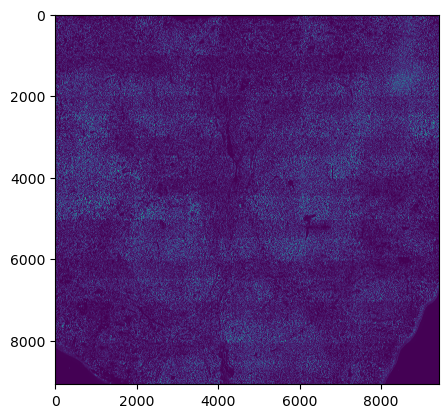

In [10]:
plt.imshow(image[:, :, 0])

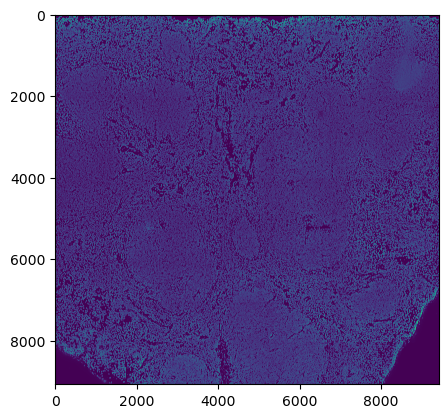

In [11]:
plt.imshow(image[:, :, 1])

In [ ]:
size = 512
truncation = 0.8
images = [image]
murine_dataset.prepare_images(images,
                               size,
                               truncation,
                               aggr = [[0], [1]],
                               pad=1000,
                               verbose=False)

## Step II: Train CellSNAP

There are two steps for training CellSNAP:
    1. Train SNAP-CNN to get CNN embedding
    2. Train SNAP-GNN to get GNN embedding

### Train SNAP-CNN

In [9]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
murine_cellsnap = CellSNAP(murine_dataset,
                           device,
                           cnn_model=True,
                           cnn_latent_dim=128,
                           gnn_latent_dim=32)

In [ ]:
murine_cellsnap.fit_snap_cnn(
                     batch_size=64,
                     learning_rate=1e-4,
                     n_epochs=3,
                     loss_fn='MSELoss',
                     OptimizerAlg='Adam',
                     optimizer_kwargs=None,
                     SchedulerAlg=None,
                     scheduler_kwargs=None,
                     print_every=1)

In [ ]:
murine_cellsnap.get_cnn_embedding(batch_size=512, path2result='../data/codex_murine/results')

We can also load a pretrained embedding if available (precomputed).

In [10]:
murine_cellsnap.cnn_embedding = np.load('../data/codex_murine/results/SNAP_CNN_embedding.npy')

### Train SNAP GNN

In [15]:
murine_cellsnap.get_snap_embedding(round=5,
                                   k=32,
                                   learning_rate=1e-3,
                                   n_epochs=5000,
                                   loss_fn='MSELoss',
                                   OptimizerAlg='Adam',
                                   optimizer_kwargs={},
                                   SchedulerAlg=None,
                                   scheduler_kwargs={},
                                   verbose=True)

===Epoch 500, the training loss is 0.00228891==
===Epoch 1000, the training loss is 0.00224401==
===Epoch 1500, the training loss is 0.00219275==
===Epoch 2000, the training loss is 0.00216473==
===Epoch 2500, the training loss is 0.00212544==
===Epoch 3000, the training loss is 0.00209665==
===Epoch 3500, the training loss is 0.00207597==
===Epoch 4000, the training loss is 0.00205425==
===Epoch 4500, the training loss is 0.00203112==
===Epoch 5000, the training loss is 0.00200632==

=========Get Current Round CellSNAP Embedding!============

===Epoch 500, the training loss is 0.00199674==
===Epoch 1000, the training loss is 0.00198838==
===Epoch 1500, the training loss is 0.00197051==
===Epoch 2000, the training loss is 0.00195778==
===Epoch 2500, the training loss is 0.00194946==
===Epoch 3000, the training loss is 0.00194281==
===Epoch 3500, the training loss is 0.00192453==
===Epoch 4000, the training loss is 0.00191430==
===Epoch 4500, the training loss is 0.00190363==
===Epoch 5

## Step III: SNAP Clustering & Visualization

/mnt/cloud1/sheng-projects/st_projects/spatial_clust/CellSNAP/tutorials/../src/CellSNAP/cellsnap.py:324: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(embedding)
/home/sheng/miniconda3/envs/super-resolution/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


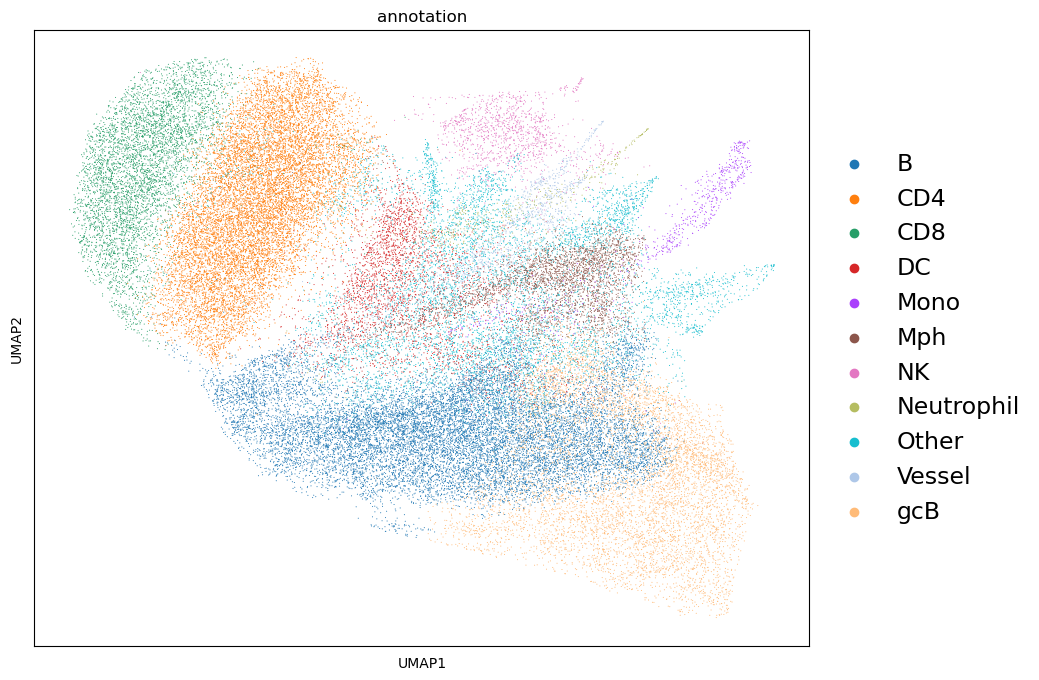

In [16]:
murine_cellsnap.visualize_umap(murine_dataset.features, murine_dataset.df['cluster.termV2'])

/mnt/cloud1/sheng-projects/st_projects/spatial_clust/CellSNAP/tutorials/../src/CellSNAP/cellsnap.py:324: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(embedding)
/home/sheng/miniconda3/envs/super-resolution/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


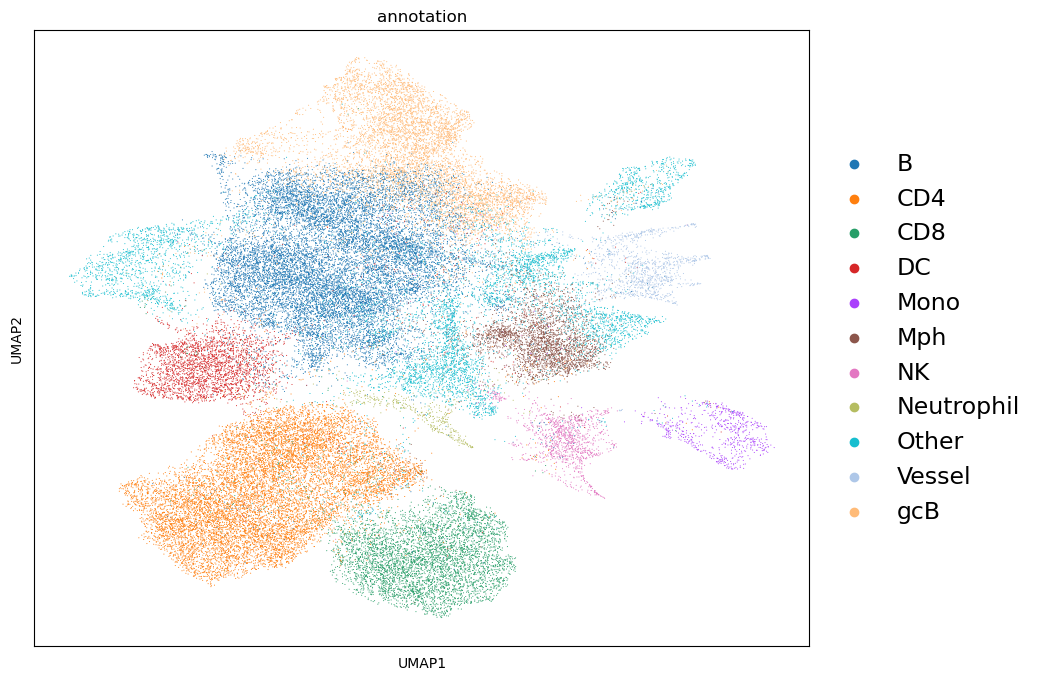

In [21]:
murine_cellsnap.visualize_umap(murine_cellsnap.snap_embedding, murine_dataset.df['cluster.termV2'])

We can also calculate cell clustering based on SNAP embedding.

In [22]:
murine_cellsnap.get_snap_clustering(neighbor=15, resolution=1.0)

/mnt/cloud1/sheng-projects/st_projects/spatial_clust/CellSNAP/tutorials/../src/CellSNAP/cellsnap.py:309: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  snap_adata = ad.AnnData(utils.drop_zero_variability_columns(embedding))


/mnt/cloud1/sheng-projects/st_projects/spatial_clust/CellSNAP/tutorials/../src/CellSNAP/cellsnap.py:324: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(embedding)
/home/sheng/miniconda3/envs/super-resolution/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


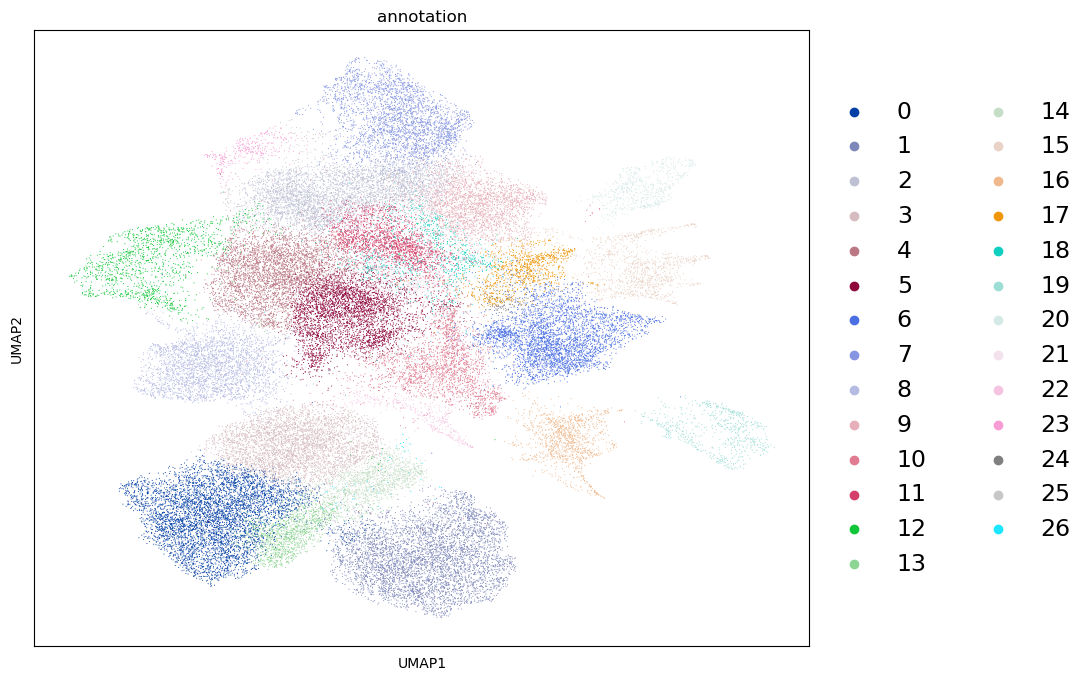

In [27]:
murine_cellsnap.visualize_umap(murine_cellsnap.snap_embedding, murine_cellsnap.snap_clustering)

## Section IV: Train CellSNAP without morphology

In [9]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
murine_cellsnap = CellSNAP(murine_dataset,
                           device,
                           cnn_model=False,
                           cnn_latent_dim=128,
                           gnn_latent_dim=32)

In [10]:
murine_cellsnap.embed_dim

32

In [11]:
murine_cellsnap.get_snap_embedding(round=5,
                                   k=32,
                                   learning_rate=1e-3,
                                   n_epochs=5000,
                                   loss_fn='MSELoss',
                                   OptimizerAlg='Adam',
                                   optimizer_kwargs={},
                                   SchedulerAlg=None,
                                   scheduler_kwargs={},
                                   verbose=True)

/home/sheng/miniconda3/envs/super-resolution/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


===Epoch 500, the training loss is 0.01044785==
===Epoch 1000, the training loss is 0.00870250==
===Epoch 1500, the training loss is 0.00793792==
===Epoch 2000, the training loss is 0.00744422==
===Epoch 2500, the training loss is 0.00712064==
===Epoch 3000, the training loss is 0.00689077==
===Epoch 3500, the training loss is 0.00672748==
===Epoch 4000, the training loss is 0.00659578==
===Epoch 4500, the training loss is 0.00649350==
===Epoch 5000, the training loss is 0.00640684==

=========Get Current Round CellSNAP Embedding!============

===Epoch 500, the training loss is 0.00633320==
===Epoch 1000, the training loss is 0.00625924==
===Epoch 1500, the training loss is 0.00620080==
===Epoch 2000, the training loss is 0.00615678==
===Epoch 2500, the training loss is 0.00611505==
===Epoch 3000, the training loss is 0.00606645==
===Epoch 3500, the training loss is 0.00602661==
===Epoch 4000, the training loss is 0.00599309==
===Epoch 4500, the training loss is 0.00597773==
===Epoch 5

/mnt/cloud1/sheng-projects/st_projects/spatial_clust/CellSNAP/tutorials/../src/CellSNAP/cellsnap.py:324: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(embedding)
/home/sheng/miniconda3/envs/super-resolution/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


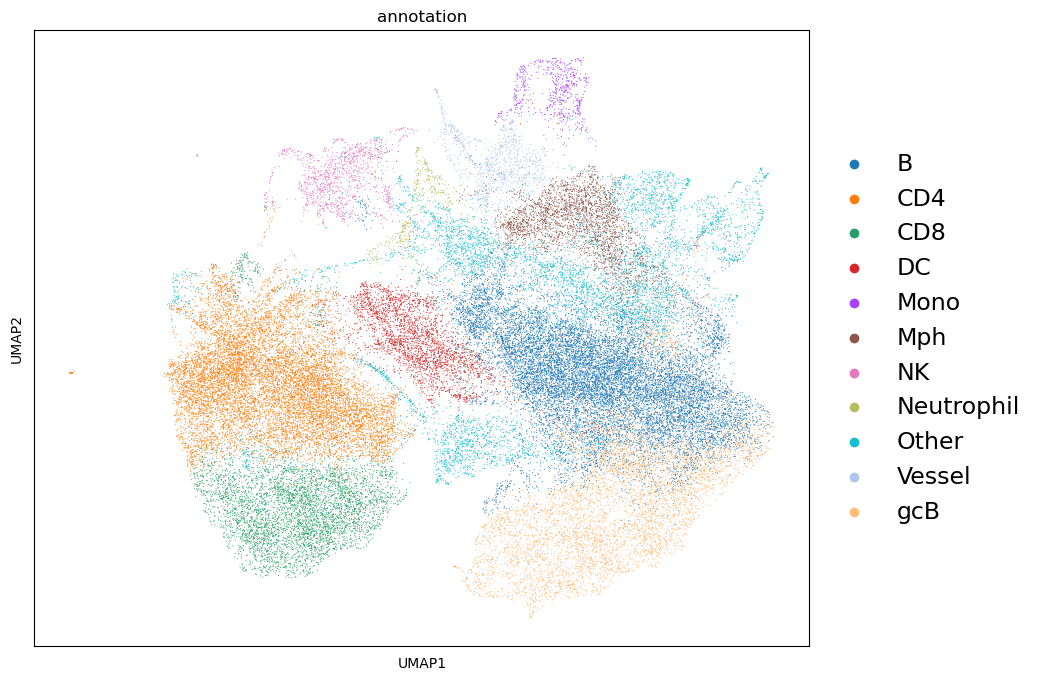

In [13]:
murine_cellsnap.visualize_umap(murine_cellsnap.snap_embedding, murine_dataset.df['cluster.termV2'])

As before, we can perform clustering

/mnt/cloud1/sheng-projects/st_projects/spatial_clust/CellSNAP/tutorials/../src/CellSNAP/cellsnap.py:309: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  snap_adata = ad.AnnData(utils.drop_zero_variability_columns(embedding))
/mnt/cloud1/sheng-projects/st_projects/spatial_clust/CellSNAP/tutorials/../src/CellSNAP/cellsnap.py:324: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(embedding)
/home/sheng/miniconda3/envs/super-resolution/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters '

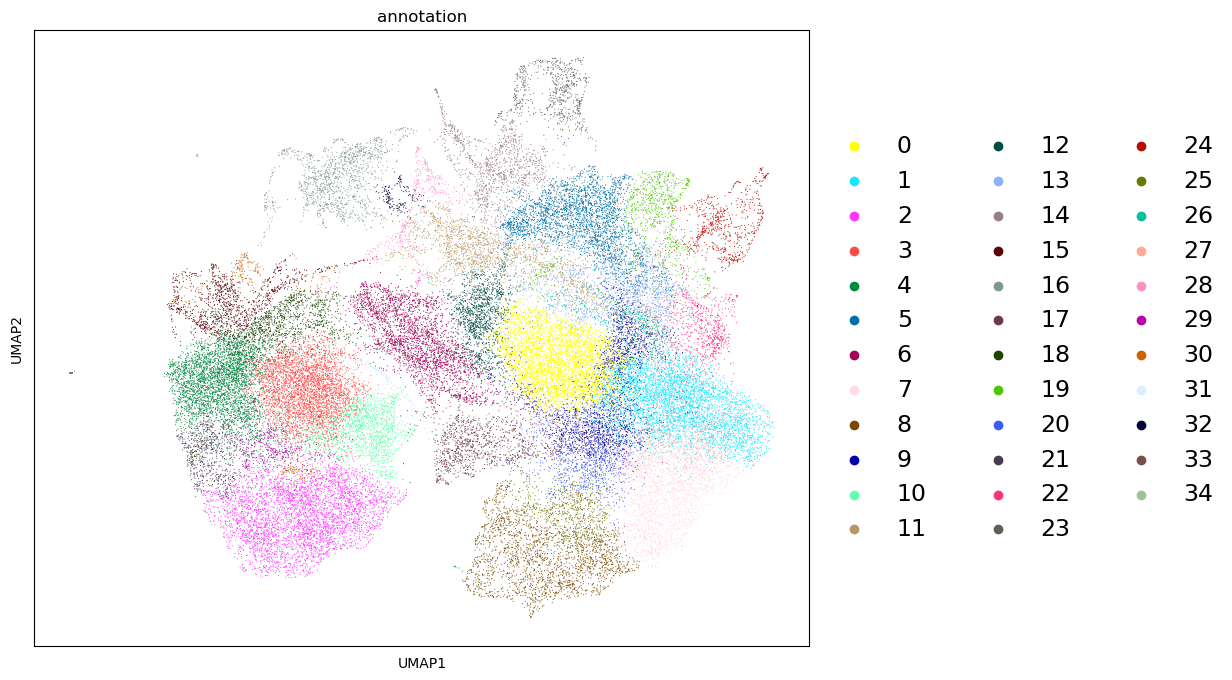

In [14]:
murine_cellsnap.get_snap_clustering(neighbor=15, resolution=1.0)
murine_cellsnap.visualize_umap(murine_cellsnap.snap_embedding, murine_cellsnap.snap_clustering)